# U-Net from scratch in PyTorch

Image segmentation is the process of dividing an image into multiple segments or regions to simplify its representation and make it easier to analyze. Segmentation provides context and meaning to individual pixels, transforming raw images into structured data that machines can interpret. By segmenting images, we can identify and extract specific objects, delineate boundaries, and even classify regions based on their content. Creating models that excel at segmentation is not just about accurate delineation; it is about enabling machines to understand and interpret visual data with precision and efficiency.

U-Net stands out as a state-of-the-art solution that has revolutionized the field of image segmentation.

https://arxiv.org/abs/1505.04597

In [ ]:
import os
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Architecture Implementation

The U-Net architecture is characterized by its U-shaped structure, which gives it its name. It consists of an encoding path, a bottleneck, and a decoding path.

The basic block of a U-Net is the **Double Convolutional Block**, which consists of two convolutions of 3x3 followed by ReLU activation. We use BatchNorm to maintain training stability (although the original paper didn't mention it, modern versions often incorporate it).

In [ ]:
class ConvBlock(nn.Module):
    """
    Implements two customizable CNN layers as a block.
    U-Net-style: Input -> Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU -> Output
    """

    def __init__(self, in_channels, out_channels, bias=False, activation=None) -> None:
        super(ConvBlock, self).__init__()
        # first convolutional layer
        self.conv1= nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=bias
        )
        # Batch Normalization to stabilize training
        self.norm1= nn.BatchNorm2d(out_channels)
        # Activation function -- ReLU is the default in U-Net
        self.activation1= nn.ReLU() if activation is None else activation

        # second convolutional layer
        self.conv2= nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=bias
        )
        # Batch Normalization to stabilize training
        self.norm2= nn.BatchNorm2d(out_channels)
        # Activation function -- ReLU is the default in U-Net
        self.activation2= nn.ReLU() if activation is None else activation


    def forward(self, x):
        x= self.conv1(x)
        x= self.norm1(x)
        x= self.activation1(x)

        x= self.conv2(x)
        x= self.norm2(x)
        x= self.activation2(x)

        return x


**Encoding Path:** Captures the context of the input image by using a series of convolutional and max-pooling layers to downsample the spatial dimensions. It "contracs" the original images, but channels grow (feature learning).

Each stage in the contracting path consists of ConvBlock followed by a 2x2 max pooling operation with a stride of 2 for downsampling. Before doing the max pooling, we save the convolutioned tensor. That convolutioned tensor is later used as skip connections and concatenated with an upsampled tensor.

In [ ]:
class EncoderBlock(nn.Module):
    """
    Implements an encoder block of the U-Net architecture.
    """

    def __init__(self, in_channels, out_channels, bias=False, activation=None) -> None:
        super(EncoderBlock, self).__init__()
        # learn features
        self.conv= ConvBlock(in_channels, out_channels, bias=bias, activation=activation)
        # reduce size by half
        self.pool= nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        skip= self.conv(x)     # feature map (also used for skip connection)
        map = self.pool(skip)  # downsampled map

        return skip, map


**Decoding Path:** Uses upsampling and convolutional layers to produce a segmentation map that has the same spatial dimensions as the input image. It "expands" the contracted images (reconstruction).

The Upsampling is done with a deconvolution (ConvTranspose2d) followed by a ConvBlock. We double the height and width of the image, then we concatenate the upsampled map with the matching encoder output (skip connection), and finally clean it up with a ConvBlock.

In [ ]:
class DecoderBlock(nn.Module):
    """
    Implements a decoder block of the U-Net architecture.
    """

    def __init__(self, in_channels, out_channels, bias=False, activation=None) -> None:
        super(DecoderBlock, self).__init__()
        # upsampling -> doubles height and width
        self.up_conv= nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2, bias=bias
        )
        # ConvBlock gets upsampled + skip features
        self.conv= ConvBlock(
            out_channels + out_channels, out_channels, bias=bias, activation=activation
        )


    def forward(self, x, skip):
        x= self.up_conv(x)              # upsample the inputs
        x= torch.cat((x, skip), dim=1)  # concat with the skip connection
        x= self.conv(x)                 # learn details

        return x


# Building the U-Net network

U-Net's strength in segmentation comes from its use of **skip connections**, which connect the encoding and decoding paths by fusing low-level and high-level features. This helps retain spatial details lost during downsampling, preserving the image's local and global context. By maintaining this spatial information, U-Net achieves more accurate segmentation masks. The skip connections assist the network in grasping the relationships between image parts, leading to improved segmentation results.

The Bottleneck is the deepest compressed representation.

In [ ]:
class UNet(nn.Module):
    """
    The U-Net architecture implementation.
    """

    def __init__(self, in_channels, num_classes=1, segmentation=True, dropout=0.1, bias=False,
                 activation=None) -> None:
        super(UNet, self).__init__()
        # Activation function -- ReLU is the default in U-Net
        activation= nn.ReLU() if activation is None else activation

        # Encoder -> shrinking image, increasing channels
        self.e1= EncoderBlock(in_channels, 64, bias=bias, activation=activation)
        self.e2= EncoderBlock(64, 128, bias=bias, activation=activation)
        self.e3= EncoderBlock(128, 256, bias=bias, activation=activation)
        self.e4= EncoderBlock(256, 512, bias=bias, activation=activation)

        # Bottleneck -> middle of the U
        self.bottleneck= ConvBlock(512, 1024, bias=bias, activation=activation)

        # Decoder -> expanding image, using skip connections
        self.d1= DecoderBlock(1024, 512, bias=bias, activation=activation)
        self.d2= DecoderBlock(512, 256, bias=bias, activation=activation)
        self.d3= DecoderBlock(256, 128, bias=bias, activation=activation)
        self.d4= DecoderBlock(128, 64, bias=bias, activation=activation)

        self.dropout= nn.Dropout(p=dropout)
        if segmentation:
            # Output layer -> 1 output channel for binary segmentation
            self.output= nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding=0, bias=bias)
        else:
            # U-Net was not designed as a classifier, but why not?
            self.output= nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=1),
                nn.Flatten(start_dim=1),
                nn.Linear(64, num_classes),
            )

        # initialize parameters with Xavier initialization
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        # Encoder
        skip1, map1= self.e1(x)
        skip2, map2= self.e2(map1)
        skip3, map3= self.e3(map2)
        skip4, map4= self.e4(map3)
        # Bottleneck
        b= self.bottleneck(map4)
        # Decoder
        d1= self.d1(b,  skip4)
        d2= self.d2(d1, skip3)
        d3= self.d3(d2, skip2)
        d4= self.d4(d3, skip1)
        # Output
        out= self.output(d4)

        return out


In [15]:
img= torch.randn(1, 3, 224, 224).to(device)  # a single image batch
model= UNet(in_channels=3, num_classes=1).to(device)
count_parameters(model)
print(model(img).shape)

model

Number of parameters: 31036672
torch.Size([1, 1, 224, 224])


UNet(
  (e1): EncoderBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation2): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (e2): EncoderBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation1): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

# Trainer Function

TODO
- Strong data augmentation for training.
- Play with different learning rate values.
- More training epochs.
- Larger batch sizes.
- Checkpointing.

In [ ]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, eval_interval=1, dice_coef=None, verbose=False):

    tr_loss_hist= []
    tr_dcs_hist = []
    vl_loss_hist= []
    vl_dcs_hist = []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        batch_loss= []
        batch_dcs = []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # --- minibatch construction ---
            images= images.float().to(device)
            labels= labels.float().to(device)

            # --- forward pass and get loss ---
            logits= model(images)

            if dice_coef is not None:
                dcs= dice_coef(logits, labels)
                batch_dcs.append(dcs.item())
            loss= criterion(logits, labels)
            batch_loss.append(loss.item())


            # --- backward pass to calculate the gradients ---
            loss.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))
        if dice_coef is not None:
            tr_dcs_hist.append(np.mean(batch_dcs))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            val_dcs = []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.float().to(device), labels.float().to(device)
                    logits= model(images)

                    if dice_coef is not None:
                        dcs_v= dice_coef(logits, labels)
                        val_dcs.append(dcs_v.item())
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            if dice_coef is not None:
                val_dcs= np.mean(val_dcs)
            val_loss= np.mean(val_loss)

            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")
                if dice_coef is not None:
                    print(f"Train DICE: {tr_dcs_hist[-1]:.4f} | Val DICE: {val_dcs:.4f}")

            # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
            if scheduler is not None:
                scheduler.step(val_loss)

        if dice_coef is not None:
            vl_dcs_hist.append(val_dcs)
        vl_loss_hist.append(val_loss)

    if dice_coef is not None:
        return tr_loss_hist, vl_loss_hist, tr_dcs_hist, vl_dcs_hist

    return tr_loss_hist, vl_loss_hist


In [ ]:
def evaluate_model(model, test_loader, device, criterion=None, dice_coef=None, verbose=False):
    model.eval()
    correct= 0
    total= 0
    batch_loss= 0
    batch_dcs= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.float().to(device), labels.float().to(device)
            logits= model(images)

            if dice_coef is not None:
                loss= criterion(logits, labels)
                dcs = dice_coef(logits, labels)

                batch_loss+= loss.item()
                batch_dcs += dcs.item()
            else:
                y_pred= torch.argmax(logits, dim=1)
                correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    if dice_coef is not None:
        eval_loss= batch_loss / len(test_loader)
        eval_dcs= batch_dcs / len(test_loader)
    else:
        acc= correct / total

    if verbose:
        if dice_coef is not None:
            print(f"Loss: {eval_loss:.4f} | DICE: {eval_dcs:.4f}")
        else:
            print(f"Accuracy: {(acc * 100):.2f}%")

    if dice_coef is not None:
        return eval_loss, eval_dcs

    return acc


In [ ]:
def plot_losses(train_loss, valid_loss, train_dice=None, valid_dice=None):
    # plot training and validation losses
    epochs= list(range(1, len(train_loss) + 1))

    if train_dice is not None:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)

    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.xticks(ticks=list(range(1, len(train_loss) + 1 + 1, 1)))
    plt.title('Losses over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()

    if train_dice is not None:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_dice, label='Training DICE')
        plt.plot(epochs, valid_dice, label='Validation DICE')
        plt.xticks(ticks=list(range(1, len(train_dice) + 1 + 1, 1)))
        plt.title('DICE Coefficient over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('DICE')
        plt.grid()
        plt.legend()
        plt.tight_layout()

    plt.show()

# Segmentation -- Loading the Carvana Dataset

https://www.kaggle.com/c/carvana-image-masking-challenge

In [ ]:
import zipfile
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from PIL import Image

In [ ]:
class CarvanaDataset(Dataset):

    def __init__(self, root_path, limit=None):
        self.root_path= root_path
        self.limit = limit
        self.images= sorted([root_path + '/train/' + i for i in os.listdir(root_path + '/train/')])[:self.limit]
        self.masks = sorted([root_path + '/train_masks/' + i for i in os.listdir(root_path + '/train_masks/')])[:self.limit]

        self.transform= transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
        ])

        if self.limit is None:
            self.limit= len(self.images)


    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        mask= Image.open(self.masks[index]).convert('L')

        img = self.transform(img)
        mask= self.transform(mask)

        return img, mask


    def __len__(self):
        return min(len(self.images), self.limit)


In [ ]:
DATASET_DIR= 'carvana/'
WORKING_DIR= 'working/'

if len(os.listdir(WORKING_DIR)) <= 1:

    with zipfile.ZipFile(DATASET_DIR + 'train.zip', 'r') as zip_file:
        zip_file.extractall(WORKING_DIR)

    with zipfile.ZipFile(DATASET_DIR + 'train_masks.zip', 'r') as zip_file:
        zip_file.extractall(WORKING_DIR)

    print(
        len(os.listdir(WORKING_DIR + 'train')),
        len(os.listdir(WORKING_DIR + 'train_masks'))
    )

train_dataset= CarvanaDataset(WORKING_DIR)
generator= torch.Generator().manual_seed(25)

train_dataset, test_dataset= random_split(train_dataset, [0.8, 0.2], generator=generator)
test_dataset, val_dataset  = random_split(test_dataset,  [0.5, 0.5], generator=generator)

batch_size= 8

train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_loader), len(val_loader)

# Evaluating Segmentation Performance with the DICE Metric

The DICE metric provides a measure of the similarity between two sets, in this case, the predicted segmentation and the ground truth segmentation. It calculates the overlap between the two sets, taking into account both the false positives and false negatives.

$$\text{DICE score} = \frac{2 * (\text{number of common elements})}{(\text{number of elements in set }A + \text{number of elements in set }B)}$$

The DICE coefficient ranges from 0 to 1, where a value closer to 1 indicates a higher degree of overlap and thus better segmentation performance. A DICE score of 1 would mean a perfect overlap between the predicted and ground truth segmentations, while a score of 0 would indicate no overlap at all.

In [ ]:
class DICE:

    def __init__(self, eps=1e-7):
        self.eps= eps

    def __call__(self, y_pred, y_true):
        y_pred_copy= y_pred.clone()

        y_pred_copy[y_pred_copy < 0.]= 0
        y_pred_copy[y_pred_copy > 0.]= 1

        intersection= abs(torch.sum(y_pred_copy * y_true))
        union= abs(torch.sum(y_pred_copy) + torch.sum(y_true))
        dice= (2.0 * intersection + self.eps) / (union + self.eps)

        return dice


# Training setup using TF32 and Fused AdamW

In [ ]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available


# --- U-Net ---
in_channels= 3
num_classes= 1
segmentation= True
dropout= 0.1

model= UNet(in_channels, num_classes, segmentation, dropout).to(device)
count_parameters(model)


# train_loader has size 509, so 10 epochs have 5,090 steps
epochs= 10
learning_rate= 3e-4

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")

criterion= nn.BCEWithLogitsLoss()
dice_coefficient= DICE()

scheduler= None

In [ ]:
tr_loss, vl_loss, tr_dice, vl_dice= trainer(model, train_loader, val_loader, optimizer, criterion,
                                            scheduler, epochs, device, dice_coef=dice_coefficient,
                                            verbose=True)

In [ ]:
# plot
plot_losses(tr_loss, vl_loss, tr_dice, vl_dice)

In [ ]:
eval_loss, eval_dcs= evaluate_model(model, test_loader, device, criterion,
                                    dice_coef=dice_coefficient, verbose=True)

# Visualize Results

In [ ]:
def random_images_inference(model, image_tensors, mask_tensors, device):
    transform= transforms.Compose([
        transforms.Resize((512, 512))
    ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth in zip(image_tensors, mask_tensors):
        # Load the image
        img= transform(image_pth)

        # Predict the imagen with the model
        pred_mask= model(img.unsqueeze(0))
        pred_mask= pred_mask.squeeze(0).permute(1, 2, 0)

        # Load the mask to compare
        mask= transform(mask_pth).permute(1, 2, 0).to(device)

        print(f"DICE coefficient: {round(float(dice_coefficient(pred_mask, mask)), 5)}")

        # Show the images
        img= img.detach().cpu().permute(1, 2, 0)
        pred_mask= pred_mask.detach().cpu()
        pred_mask[pred_mask < 0]= 0
        pred_mask[pred_mask > 0]= 1

        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.subplot(133), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.show()


In [ ]:
n= 10

image_tensors= []
mask_tensors = []

for _ in range(n):
    random_index = random.randint(0, len(test_loader.dataset) - 1)
    random_sample= test_loader.dataset[random_index]

    image_tensors.append(random_sample[0])
    mask_tensors.append(random_sample[1])

random_images_inference(model, image_tensors, mask_tensors, device="cpu")

In [ ]:
from google.colab import runtime
runtime.unassign()

# Classification -- Loading the CIFAR10 Dataset

In [ ]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std= [0.2023, 0.1994, 0.2010]), # CIFAR-10 stats
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 128
train_loader= DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 30.0MB/s]


In [ ]:
len(train_loader), len(val_loader)

(352, 40)

# Training setup using TF32, Fused AdamW, and Label Smoothing

In [ ]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available


# --- U-Net ---
in_channels= 3
num_classes= 10
segmentation= False
dropout= 0.1

model= UNet(in_channels, num_classes, segmentation, dropout).to(device)
count_parameters(model)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 5e-4

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss(label_smoothing=0.1)
# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

Number of parameters: 31037258
Using fused AdamW: True


In [ ]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 1.8373 | Val Loss: 1.7031 | dt/epoch: 255497.07ms
Epoch: 1 | Train Loss: 1.5375 | Val Loss: 1.5657 | dt/epoch: 253427.10ms
Epoch: 2 | Train Loss: 1.3497 | Val Loss: 1.3960 | dt/epoch: 253368.25ms
Epoch: 3 | Train Loss: 1.2287 | Val Loss: 1.2213 | dt/epoch: 253465.64ms
Epoch: 4 | Train Loss: 1.1429 | Val Loss: 1.4235 | dt/epoch: 253571.41ms
Epoch: 5 | Train Loss: 1.0830 | Val Loss: 1.2278 | dt/epoch: 254166.69ms
Epoch: 6 | Train Loss: 1.0283 | Val Loss: 1.0704 | dt/epoch: 254149.52ms
Epoch: 7 | Train Loss: 0.9830 | Val Loss: 1.1291 | dt/epoch: 253595.28ms
Epoch: 8 | Train Loss: 0.9395 | Val Loss: 1.1003 | dt/epoch: 253830.82ms
Epoch: 9 | Train Loss: 0.9068 | Val Loss: 1.0836 | dt/epoch: 253341.20ms
Epoch: 10 | Train Loss: 0.8764 | Val Loss: 1.0564 | dt/epoch: 254003.40ms
Epoch: 11 | Train Loss: 0.8460 | Val Loss: 1.0018 | dt/epoch: 253733.68ms
Epoch: 12 | Train Loss: 0.8239 | Val Loss: 0.9474 | dt/epoch: 254026.07ms
Epoch: 13 | Train Loss: 0.7993 | Val Loss: 0.970

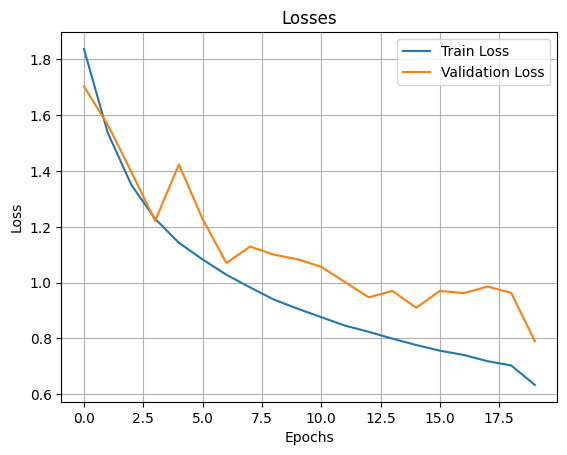

In [ ]:
# plot
plot_losses(tr_loss, vl_loss)

In [ ]:
unet_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 88.54%


In [ ]:
# https://medium.com/@alejandro.itoaramendia/decoding-the-u-net-a-complete-guide-810b1c6d56d8
# https://medium.com/@fernandopalominocobo/mastering-u-net-a-step-by-step-guide-to-segmentation-from-scratch-with-pytorch-6a17c5916114
# https://medium.com/@AIchemizt/u-net-architecture-explained-a-simple-guide-with-pytorch-code-fc33619f2b75